In [1]:
import networkx as nx 
import osmnx as ox 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
from funcs import * 
import grinpy

In [2]:
# Load graph

H = nx.read_gpickle('data/BaseGraph03_NOR_wagrades.pickle')

## Graph summary statistics

In [3]:
# Computes some summary statistics of the basegraph

density = nx.density(H)
deg = sorted(H.degree, key=lambda x: x[1], reverse=True)
deg = [n[1] for n in deg]
print("Nodes:\t\t\t", len(H.nodes))
print("Edges:\t\t\t", len(H.edges))
print("Network density:\t", round(density,4))
print("Maximum degree:\t\t", max(deg))
print("Average degree:\t\t", round(np.mean(deg), 4))

Nodes:			 18183
Edges:			 26324
Network density:	 0.0002
Maximum degree:		 5
Average degree:		 2.8955


In [4]:
# Store degrees, count them and create list containing histogram values

degrees = dict(H.degree()) # dictionary node:degree
values = sorted(set(degrees.values())) 
hist = [list(degrees.values()).count(x) for x in values]

In [5]:
plt.figure(figsize = (15,10))
plt.bar(values, hist) # in-degree
plt.xlabel('Degree' , fontsize = 15)
plt.ylabel('Number of nodes' , fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('figures/degree_dist.png', dpi = 400, bbox_inches = 'tight')
plt.close()

In [6]:
# Retrieve absolute value of gradients

lengths = []
for i in H.edges:
    length = H.edges[i]['length']
    lengths.append(length)

grades = [abs(H.edges[i]['wa_grade']) for i in H.edges]

In [7]:
plt.figure(figsize = (15,10))
sns.scatterplot(x = lengths, y = grades)
plt.xlabel('Length', fontsize = 15)
plt.ylabel('Abs. gradient', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('figures/lengths_gradient_scatter.png', dpi = 400, bbox_inches = 'tight')
plt.close()

## Plot distribution of grades and elevation


In [8]:
grades = [H.edges[i]['wa_grade'] for i in H.edges]
elevations = [H.nodes[i]['elevation'] if float('-inf') < H.nodes[i]['elevation'] < float('inf') else 0 for i in H.nodes]

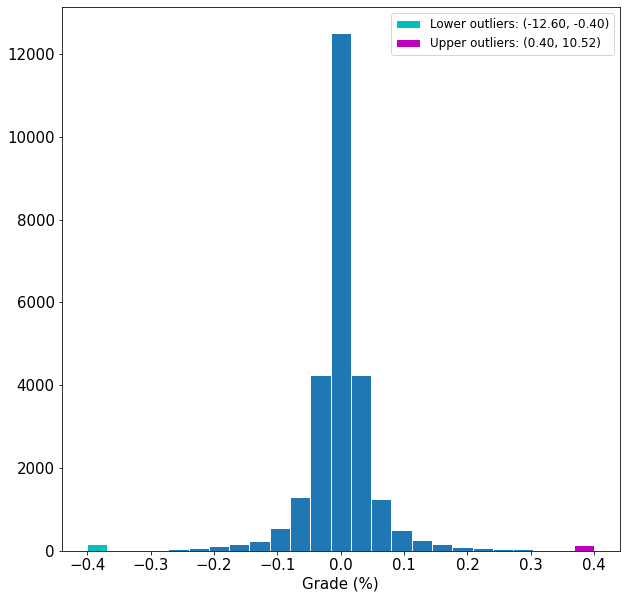

In [9]:
plt.figure(figsize = (10,10))
# plt.title("Distribution of grade, with binned outliers")
plt.xlabel("Grade (%)", fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
outlier_aware_hist(grades, *calculate_bounds(grades))
plt.savefig("figures/dist_grade_binnedoutliers.png", dpi = 400, bbox_inches = 'tight')   

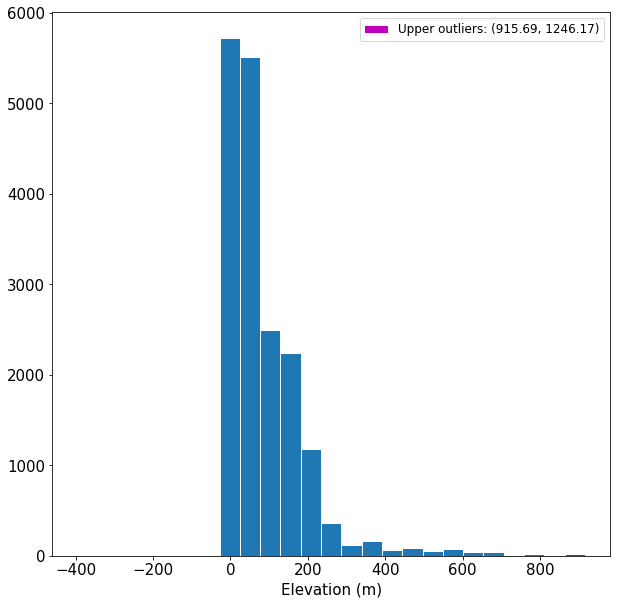

In [10]:
plt.figure(figsize = (10,10))
# plt.title("Distribution of elevation, with binned outliers")
plt.xlabel("Elevation (m)", fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
outlier_aware_hist(elevations, *calculate_bounds(elevations))  
plt.savefig("figures/dist_elev_binnedoutliers.png", dpi = 400, bbox_inches = 'tight', transparent = False)   

## Plot node elevations

In [11]:
%%capture
# Capture outoput because figure is very large

# Plot node elevation with colorbar legend,
nodes, edges = ox.graph_to_gdfs(H)
cmap = plt.cm.get_cmap('coolwarm')

nc = ox.plot.get_node_colors_by_attr(H, 'elevation', cmap=cmap, equal_size=True)


# ADD CUSTOM MINUMUM AND MAXIMUM VALUES RETRIEVED FROM THE OUTLIER DETECTOR
norm=plt.Normalize(vmin=-151, vmax=1246)
# norm=plt.Normalize(vmin=nodes['elevation'].min(), vmax=nodes['elevation'].max())
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, ax = ox.plot_graph(H, figsize=(15,15), node_color=nc, edge_color='white', edge_linewidth = 1.5, node_size=10, bgcolor='white')

cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax, orientation = "vertical")

fig.savefig('figures/norway_elevated.png', dpi = 400, bbox_inches = 'tight')

### Plot reachability graph degree distributions

In [12]:
# Load data
from scipy import sparse
A = sparse.load_npz('data/Reachability_03_10kwh_UNDIRECTED.npz')
B = sparse.load_npz('data/Reachability_03_15kwh_UNDIRECTED.npz')
C = sparse.load_npz('data/Reachability_03_20kwh_UNDIRECTED.npz')
D = sparse.load_npz('data/Reachability_03_30kwh_UNDIRECTED.npz')
E = sparse.load_npz('data/Reachability_03_40kwh_UNDIRECTED.npz')

In [13]:
# This one takes A WHILE
# There is probably a better way to do it

A_degrees = [A[:,i].count_nonzero() for i in range(A.shape[0])]
B_degrees = [B[:,i].count_nonzero() for i in range(B.shape[0])]
C_degrees = [C[:,i].count_nonzero() for i in range(C.shape[0])]
D_degrees = [D[:,i].count_nonzero() for i in range(D.shape[0])]
E_degrees = [E[:,i].count_nonzero() for i in range(E.shape[0])]

In [14]:
degs = [A_degrees, B_degrees, C_degrees, D_degrees, E_degrees]

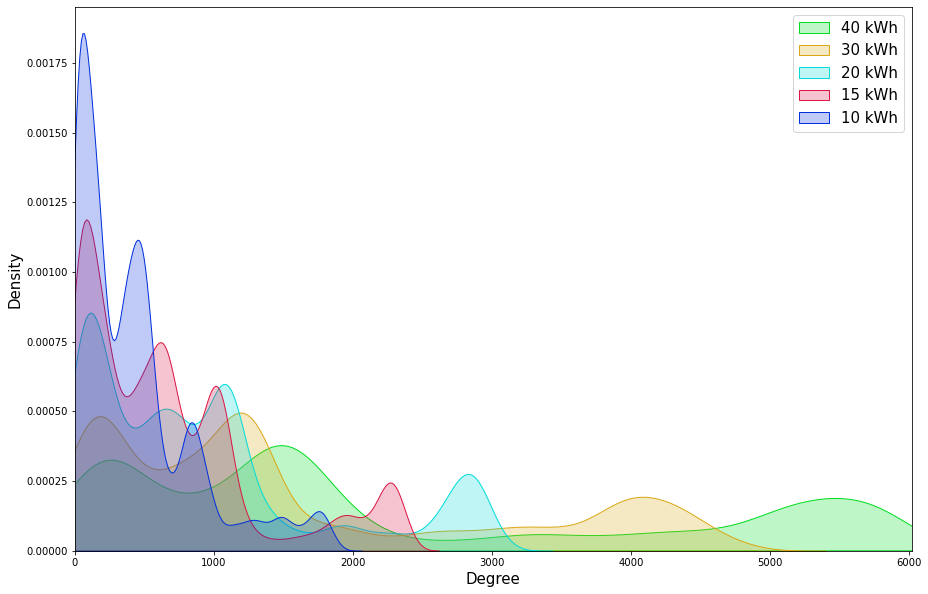

In [15]:
#kdeplot of degree distribution

max_diam = max(degs[4])
plt.figure(figsize = (15,10))
ranges = ["40 kWh", "30 kWh", "20 kWh", "15 kWh", "10 kWh"]

# First generate counts
sns.kdeplot(degs[4], color = "#00DE21", fill = "#00DE21").set(xlim=(0, max_diam))
sns.kdeplot(degs[3], color = "#DBA816", fill = "#DBA816").set(xlim=(0, max_diam))
sns.kdeplot(degs[2], color = "#01DBDB", fill = "#01DBDB").set(xlim=(0, max_diam))
sns.kdeplot(degs[1], color = "#DB1644", fill = "#DB1644").set(xlim=(0, max_diam))
sns.kdeplot(degs[0], color = "#002FDE", fill = "#002FDE").set(xlim=(0, max_diam))

plt.legend(ranges, prop={'size': 15})
plt.xlabel("Degree", fontsize = 15)
plt.ylabel("Density", fontsize = 15)

plt.savefig('figures/reachabilit_degree_dist.png', dpi = 400, bbox_inches = 'tight')
plt.show()